In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

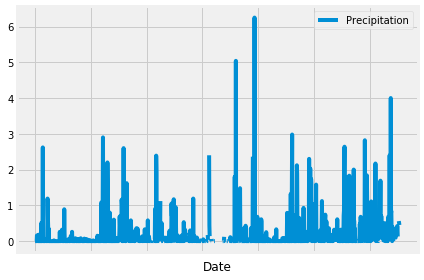

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
previous_year = dt.date.today() - dt.timedelta(days=730)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= previous_year).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df=pd.DataFrame(results,columns=['Date','Precipitation'])
# Sort the dataframe by date
df.set_index(df['Date'],inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)
plt.xticks(rotation="45")
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation 
df.describe()

,Precipitation
count,1188.000000
mean,0.174907
std,0.466654
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


![describe](Images/describe.png)

In [18]:
station_results = session.query(func.count(Station.station)).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
station_results


[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Station.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 24948),
 ('USC00519397', 24516),
 ('USC00513117', 24381),
 ('USC00519523', 24021),
 ('USC00516128', 23508),
 ('USC00514830', 19818),
 ('USC00511918', 17811),
 ('USC00517948', 12348),
 ('USC00518838', 4599)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station=="USC00519281").all()


[(54.0, 85.0, 71.66378066378067)]

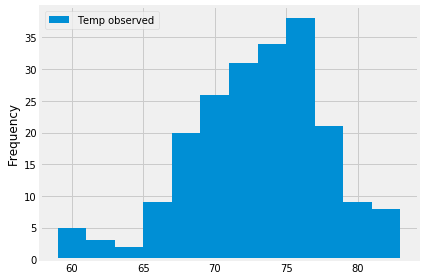

In [26]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2 = session.query(Measurement.tobs).filter(Measurement.station=="USC00519281")\
.filter(Measurement.date>=previous_year).all()
df2=pd.DataFrame(results2,columns=["Temp observed"])
df2.plot.hist(bins=12)
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps("2016-12-29","2017-01-03"))

[(62.0, 69.47222222222223, 77.0)]


In [30]:
###SKIPPED###



In [34]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = "2016-10-10"
end_date = "2016-10-17"
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
session.query(*sel).\
filter(Measurement.station==Station.station).\
filter(Measurement.date>=start_date).\
filter(Measurement.date<=end_date).\
group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.1400000000000001),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.36000000000000004),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.12),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.08),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.08),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]